#### Compute pathway acts for the subnetwork created by looking for hubs (TDA mega cluster) and their targets

In [1]:
import pandas as pd
import numpy as np
import decoupler as dc
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from upsetplot import UpSet, from_contents
plt.rcParams['svg.fonttype'] = 'none'

/home/mmultari/miniconda3/envs/GRN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GRN = pd.read_csv('../Data/Network_GRN_HIVE_curated.txt',sep='\t')
GRN.rename(columns={'tf.name':'source','target.name':'target'}, inplace=True)
Dataset = pd.read_csv('../DEA/Merge_stat_all.tsv',index_col=0, sep='\t')

In [3]:
Dataset = Dataset.reset_index()
Dataset['OLN'] = Dataset['index'].str.extract(r'(Solyc\d+g\d+)')
Dataset = Dataset.rename(columns={'index':'Gene_Name'})
Dataset.columns=Dataset.columns.str.replace('stat_','', regex=False)
Dataset = Dataset.fillna(0)

In [4]:
hubs_tda = pd.read_csv('./Results_hubs_by_TDA_mega_cluster.tsv',sep='\t')

In [5]:
GRN_hubs = GRN[GRN['source'].isin(hubs_tda['OLN'])]
## ok 

In [6]:
filtered_dataset = Dataset[Dataset['OLN'].isin(GRN_hubs['source']) | Dataset['OLN'].isin(GRN_hubs['target'])]
filtered_dataset = filtered_dataset.set_index('OLN')
filtered_dataset.index.name=None

In [7]:
# len(pd.concat([GRN_hubs['source'], GRN_hubs['target']]).unique()) == filtered_dataset.shape[0]

In [8]:
conditions = ['Pinfestans','Cfulvum','PSTVd_S23','PSTVd_M','Bcinerea','Mincognita_7dpi','Mincognita_14dpi']
matrix = filtered_dataset[conditions].T

In [9]:
sly_kegg = pd.read_csv('../Data/KEGG_background.txt',sep='\t')
sly_kegg = sly_kegg[['gene.name','pathway.name']].drop_duplicates()
sly_kegg.rename(columns={'pathway.name':'source','gene.name':'target'}, inplace=True)
sly_kegg_filt = sly_kegg[sly_kegg['target'].isin(matrix.columns)]

In [10]:
pathway_acts, pathway_pvals = dc.run_mlm(mat=matrix, net=sly_kegg_filt, verbose=True, weight=None, min_n=5)

Running mlm on mat with 7 samples and 546 targets for 5 sources.


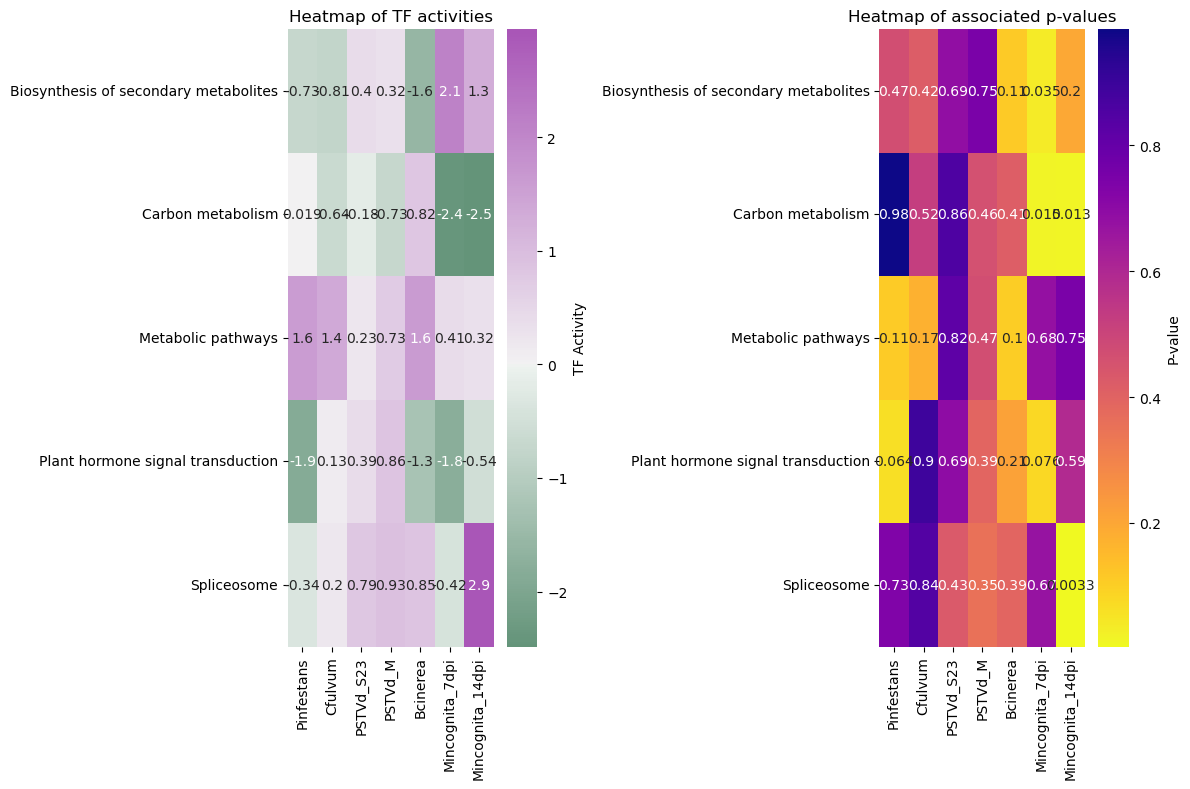

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,8), tight_layout=True)

axes[0].set_title('Heatmap of TF activities')
sns.heatmap(pathway_acts.T, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), ax=axes[0], center=0, annot=True, cbar_kws={'label': 'TF Activity'})
axes[1].set_title('Heatmap of associated p-values')
sns.heatmap(pathway_pvals.T, cmap='plasma_r', ax=axes[1], annot=True,cbar_kws={'label': 'P-value'})

plt.savefig('Plot/Heatmap_activity_hubs_GRN.svg', format='svg')
plt.show()